# Preparação do Dataset AcTBeCalf para HAR-Transformer

Este notebook prepara os dados do AcTBeCalf no formato necessário para o modelo HAR-Transformer:
- Janelas de 75 amostras (3 segundos a 25 Hz)
- 3 canais: accX, accY, accZ
- Sequence-to-sequence: labels por timestep
- Treino: janelas puras (mesmo comportamento)
- Teste/Validação: janelas consecutivas (podem cruzar comportamentos)


In [1]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações
WINDOW_SIZE = 75  # 3 segundos a 25 Hz
FREQ = 25  # Hz
STRIDE_TRAIN = WINDOW_SIZE // 2  # Overlap de 50% para treino
STRIDE_TEST = WINDOW_SIZE  # Sem overlap para teste/validação

print(f"Configurações:")
print(f"  Window size: {WINDOW_SIZE} amostras ({WINDOW_SIZE/FREQ:.1f} segundos)")
print(f"  Stride treino: {STRIDE_TRAIN}")
print(f"  Stride teste/val: {STRIDE_TEST}")


Configurações:
  Window size: 75 amostras (3.0 segundos)
  Stride treino: 37
  Stride teste/val: 75


## 1. Carregamento dos Dados


In [2]:
# Carregar dados usando Polars (mais eficiente)
print("Carregando AcTBeCalf.parquet...")
df_pl = pl.read_parquet('AcTBeCalf.parquet')

# Converter para Pandas para facilitar manipulação
df = df_pl.to_pandas()

print(f"✅ Dados carregados: {len(df):,} amostras")
print(f"📊 Colunas: {list(df.columns)}")
print(f"🐄 Bezerros únicos: {df['calfId'].nunique()}")
print(f"📋 Comportamentos únicos: {df['behaviour'].nunique()}")
print(f"🔢 Segmentos únicos (segId): {df['segId'].nunique()}")


Carregando AcTBeCalf.parquet...
✅ Dados carregados: 2,467,162 amostras
📊 Colunas: ['dateTime', 'calfId', 'accX', 'accY', 'accZ', 'behaviour', 'segId']
🐄 Bezerros únicos: 30
📋 Comportamentos únicos: 50
🔢 Segmentos únicos (segId): 4016


## 2. Mapeamento de Labels e Divisão por Bezerro


In [3]:
# Criar mapeamento de comportamentos para inteiros
behaviours = sorted(df['behaviour'].unique())
label_map = {behaviour: i for i, behaviour in enumerate(behaviours)}
int_to_label = {i: behaviour for behaviour, i in label_map.items()}

num_classes = len(behaviours)
print(f"📋 Número de classes: {num_classes}")
print(f"📝 Primeiros 10 comportamentos: {behaviours[:10]}")

# Mapear labels
df['label'] = df['behaviour'].map(label_map).astype('int64')

# Obter bezerros únicos
unique_calves = sorted(df['calfId'].unique())
num_calves = len(unique_calves)
print(f"\n🐄 Total de bezerros: {num_calves}")
print(f"📋 Bezerros: {unique_calves}")

# Dividir bezerros: 24 treino, 2 validação, 4 teste
np.random.seed(42)
shuffled_calves = np.random.permutation(unique_calves)

train_calves = shuffled_calves[:24].tolist()
val_calves = shuffled_calves[24:26].tolist()
test_calves = shuffled_calves[26:30].tolist()

print(f"\n📊 Divisão de bezerros:")
print(f"  Treino: {sorted(train_calves)} ({len(train_calves)} bezerros)")
print(f"  Validação: {sorted(val_calves)} ({len(val_calves)} bezerros)")
print(f"  Teste: {sorted(test_calves)} ({len(test_calves)} bezerros)")

# Filtrar dados por conjunto
df_train = df[df['calfId'].isin(train_calves)].copy()
df_val = df[df['calfId'].isin(val_calves)].copy()
df_test = df[df['calfId'].isin(test_calves)].copy()

print(f"\n📊 Amostras por conjunto:")
print(f"  Treino: {len(df_train):,} amostras")
print(f"  Validação: {len(df_val):,} amostras")
print(f"  Teste: {len(df_test):,} amostras")


📋 Número de classes: 50
📝 Primeiros 10 comportamentos: ['SRS', 'abnormal', 'backward', 'cough', 'cross-suckle_other', 'cross-suckle_udder', 'defecation', 'drinking', 'drinking_electrolytes', 'drinking_milk']

🐄 Total de bezerros: 30
📋 Bezerros: ['1302', '1303', '1306', '1308', '1312', '1314', '1319', '1320', '1328', '1329', '1333', '1335', '1336', '1343', '1351', '1353', '1357', '1372', '1398', '1403', '1405', '1408', '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455']

📊 Divisão de bezerros:
  Treino: ['1302', '1303', '1306', '1308', '1312', '1314', '1328', '1329', '1335', '1336', '1343', '1353', '1357', '1372', '1398', '1408', '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455'] (24 bezerros)
  Validação: ['1320', '1405'] (2 bezerros)
  Teste: ['1319', '1333', '1351', '1403'] (4 bezerros)

📊 Amostras por conjunto:
  Treino: 1,867,879 amostras
  Validação: 223,673 amostras
  Teste: 375,610 amostras


## 3. Extração de Janelas - Treino (Apenas Comportamentos Puros)


In [4]:
def extract_pure_windows(df, window_size, stride):
    """
    Extrai janelas apenas de segmentos (segId) com mesmo comportamento.
    Cada janela contém apenas um comportamento (puro).
    """
    signals_list = []
    labels_list = []

    # Agrupar por segId (cada segId tem o mesmo comportamento)
    for seg_id, group in df.groupby('segId'):
        n = len(group)

        # Apenas segmentos com tamanho suficiente
        if n >= window_size:
            # Resetar índice do grupo para facilitar indexação
            group = group.reset_index(drop=True)

            # Extrair sinais do segmento
            seg_signals = group[['accX', 'accY', 'accZ']].values.astype('float32')
            seg_labels = group['label'].values.astype('int64')

            # Criar janelas com stride
            for i in range(0, n - window_size + 1, stride):
                window_signal = seg_signals[i:i+window_size]
                window_label = seg_labels[i:i+window_size]

                # Verificar se a janela é pura (todos os labels são iguais)
                if len(np.unique(window_label)) == 1:
                    signals_list.append(window_signal)
                    labels_list.append(window_label)

    if len(signals_list) == 0:
        return np.array([]), np.array([])

    signals = np.stack(signals_list, axis=0)
    labels = np.stack(labels_list, axis=0)

    return signals, labels

print("Extraindo janelas de TREINO (comportamentos puros)...")
X_train, y_train = extract_pure_windows(df_train, WINDOW_SIZE, STRIDE_TRAIN)
print(f"✅ Treino: {X_train.shape[0]:,} janelas")
print(f"   Shape sinais: {X_train.shape}")
print(f"   Shape labels: {y_train.shape}")


Extraindo janelas de TREINO (comportamentos puros)...
✅ Treino: 45,580 janelas
   Shape sinais: (45580, 75, 3)
   Shape labels: (45580, 75)


## 4. Extração de Janelas - Teste/Validação (Consecutivas, Podem Cruzar Comportamentos)


In [5]:
def extract_consecutive_windows(df, window_size, stride):
    """
    Extrai janelas consecutivas que podem cruzar diferentes segId/comportamentos.
    Ordena por calfId e dateTime para manter ordem temporal.
    """
    signals_list = []
    labels_list = []

    # Ordenar por bezerro e tempo
    df_sorted = df.sort_values(['calfId', 'dateTime']).reset_index(drop=True)

    # Extrair sinais e labels
    all_signals = df_sorted[['accX', 'accY', 'accZ']].values.astype('float32')
    all_labels = df_sorted['label'].values.astype('int64')

    # Criar janelas consecutivas
    n = len(df_sorted)
    for i in range(0, n - window_size + 1, stride):
        window_signal = all_signals[i:i+window_size]
        window_label = all_labels[i:i+window_size]

        signals_list.append(window_signal)
        labels_list.append(window_label)

    if len(signals_list) == 0:
        return np.array([]), np.array([])

    signals = np.stack(signals_list, axis=0)
    labels = np.stack(labels_list, axis=0)

    return signals, labels

print("Extraindo janelas de VALIDAÇÃO (consecutivas)...")
X_val, y_val = extract_consecutive_windows(df_val, WINDOW_SIZE, STRIDE_TEST)
print(f"✅ Validação: {X_val.shape[0]:,} janelas")
print(f"   Shape sinais: {X_val.shape}")
print(f"   Shape labels: {y_val.shape}")

print("\nExtraindo janelas de TESTE (consecutivas)...")
X_test, y_test = extract_consecutive_windows(df_test, WINDOW_SIZE, STRIDE_TEST)
print(f"✅ Teste: {X_test.shape[0]:,} janelas")
print(f"   Shape sinais: {X_test.shape}")
print(f"   Shape labels: {y_test.shape}")


Extraindo janelas de VALIDAÇÃO (consecutivas)...
✅ Validação: 2,982 janelas
   Shape sinais: (2982, 75, 3)
   Shape labels: (2982, 75)

Extraindo janelas de TESTE (consecutivas)...
✅ Teste: 5,008 janelas
   Shape sinais: (5008, 75, 3)
   Shape labels: (5008, 75)


## 5. Estatísticas dos Dados


In [6]:
print("=" * 80)
print("ESTATÍSTICAS DOS DADOS PREPARADOS")
print("=" * 80)

print(f"\n📊 Formato dos dados:")
print(f"  Treino:   sinais {X_train.shape}, labels {y_train.shape}")
print(f"  Validação: sinais {X_val.shape}, labels {y_val.shape}")
print(f"  Teste:    sinais {X_test.shape}, labels {y_test.shape}")

print(f"\n📈 Estatísticas dos sinais (Treino):")
print(f"  Mean: {np.mean(X_train, axis=(0, 1))}")
print(f"  Std:  {np.std(X_train, axis=(0, 1))}")
print(f"  Min:  {np.min(X_train, axis=(0, 1))}")
print(f"  Max:  {np.max(X_train, axis=(0, 1))}")

print(f"\n📋 Distribuição de classes (Treino):")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for label_idx, count in zip(unique_train[:10], counts_train[:10]):
    print(f"  {int_to_label[label_idx]}: {count:,} timesteps")
if len(unique_train) > 10:
    print(f"  ... e mais {len(unique_train) - 10} classes")

print(f"\n📋 Distribuição de classes (Validação):")
unique_val, counts_val = np.unique(y_val, return_counts=True)
print(f"  {len(unique_val)} classes únicas")
print(f"  Total timesteps: {y_val.size:,}")

print(f"\n📋 Distribuição de classes (Teste):")
unique_test, counts_test = np.unique(y_test, return_counts=True)
print(f"  {len(unique_test)} classes únicas")
print(f"  Total timesteps: {y_test.size:,}")


ESTATÍSTICAS DOS DADOS PREPARADOS

📊 Formato dos dados:
  Treino:   sinais (45580, 75, 3), labels (45580, 75)
  Validação: sinais (2982, 75, 3), labels (2982, 75)
  Teste:    sinais (5008, 75, 3), labels (5008, 75)

📈 Estatísticas dos sinais (Treino):
  Mean: [ 0.78908503 -0.16192047  0.05407684]
  Std:  [0.24084021 0.348876   0.3817148 ]
  Min:  [-4.3125   -7.484375 -3.625   ]
  Max:  [7.859375 4.96875  5.890625]

📋 Distribuição de classes (Treino):
  SRS: 225 timesteps
  abnormal: 20,775 timesteps
  backward: 6,675 timesteps
  cough: 300 timesteps
  cross-suckle_other: 1,650 timesteps
  cross-suckle_udder: 3,150 timesteps
  defecation: 3,225 timesteps
  drinking: 17,550 timesteps
  drinking_electrolytes: 1,050 timesteps
  drinking_milk: 352,350 timesteps
  ... e mais 38 classes

📋 Distribuição de classes (Validação):
  31 classes únicas
  Total timesteps: 223,650

📋 Distribuição de classes (Teste):
  27 classes únicas
  Total timesteps: 375,600


## 6. Visualização da Distribuição


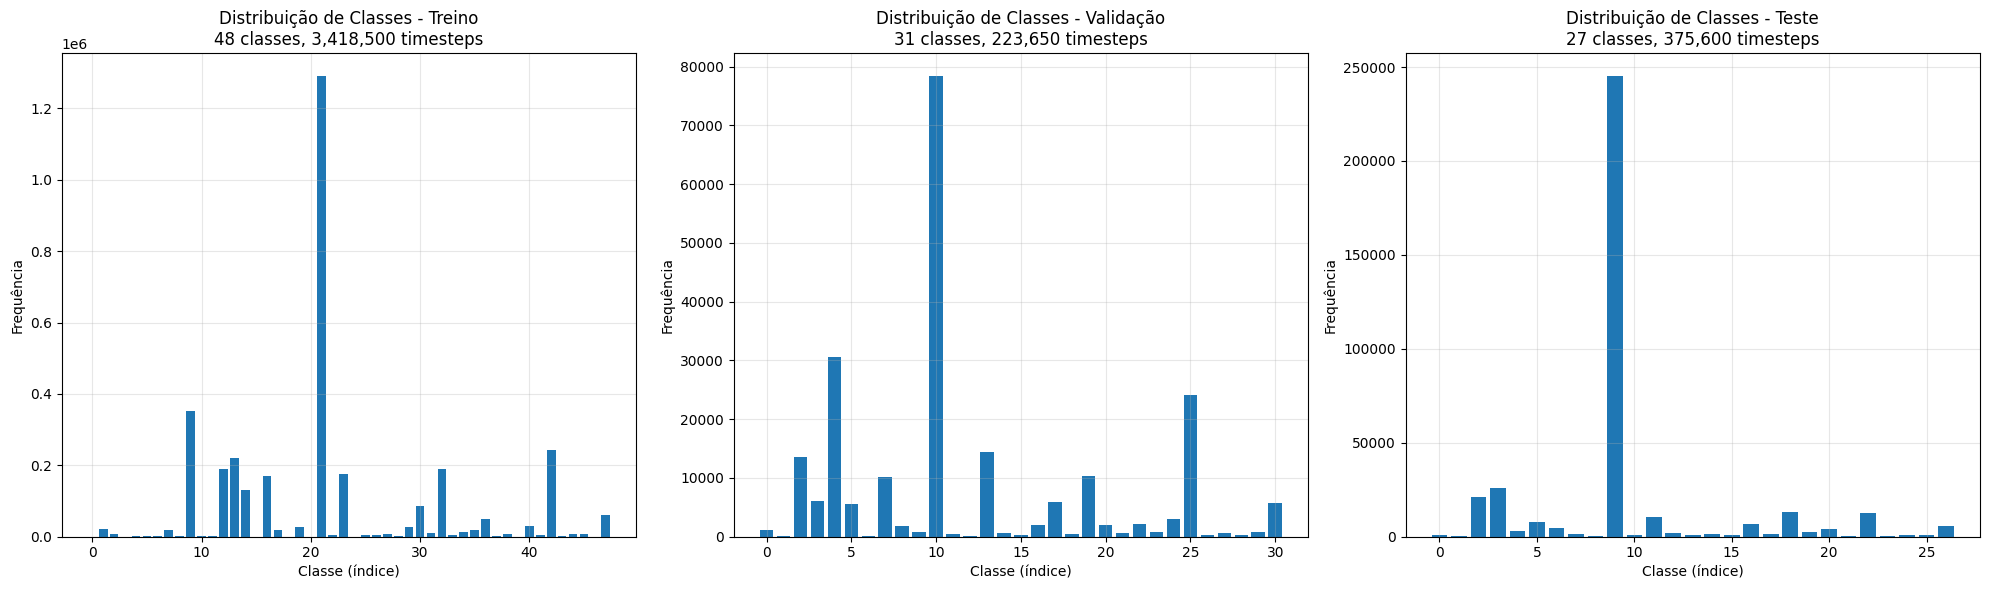

In [7]:
# Visualizar distribuição de classes
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Treino
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[0].bar(range(len(unique_train)), counts_train)
axes[0].set_title(f'Distribuição de Classes - Treino\n{len(unique_train)} classes, {y_train.size:,} timesteps')
axes[0].set_xlabel('Classe (índice)')
axes[0].set_ylabel('Frequência')
axes[0].grid(True, alpha=0.3)

# Validação
unique_val, counts_val = np.unique(y_val, return_counts=True)
axes[1].bar(range(len(unique_val)), counts_val)
axes[1].set_title(f'Distribuição de Classes - Validação\n{len(unique_val)} classes, {y_val.size:,} timesteps')
axes[1].set_xlabel('Classe (índice)')
axes[1].set_ylabel('Frequência')
axes[1].grid(True, alpha=0.3)

# Teste
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(range(len(unique_test)), counts_test)
axes[2].set_title(f'Distribuição de Classes - Teste\n{len(unique_test)} classes, {y_test.size:,} timesteps')
axes[2].set_xlabel('Classe (índice)')
axes[2].set_ylabel('Frequência')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Salvar Dataset


In [8]:
# Salvar dataset no formato .npz similar ao KU-HAR
output_file = 'actbecalf_dataset.npz'

print(f"Salvando dataset em {output_file}...")
np.savez_compressed(
    output_file,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    label_map=label_map,
    int_to_label=int_to_label,
    num_classes=num_classes,
    train_calves=train_calves,
    val_calves=val_calves,
    test_calves=test_calves
)

print(f"✅ Dataset salvo com sucesso!")
print(f"\n📦 Conteúdo do arquivo:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - X_val: {X_val.shape}")
print(f"  - y_val: {y_val.shape}")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_test: {y_test.shape}")
print(f"  - label_map: mapeamento comportamento -> índice")
print(f"  - int_to_label: mapeamento índice -> comportamento")
print(f"  - num_classes: {num_classes}")
print(f"  - train_calves, val_calves, test_calves: divisão dos bezerros")


Salvando dataset em actbecalf_dataset.npz...
✅ Dataset salvo com sucesso!

📦 Conteúdo do arquivo:
  - X_train: (45580, 75, 3)
  - y_train: (45580, 75)
  - X_val: (2982, 75, 3)
  - y_val: (2982, 75)
  - X_test: (5008, 75, 3)
  - y_test: (5008, 75)
  - label_map: mapeamento comportamento -> índice
  - int_to_label: mapeamento índice -> comportamento
  - num_classes: 50
  - train_calves, val_calves, test_calves: divisão dos bezerros


## 8. Verificação do Dataset Salvo


In [9]:
# Verificar se o arquivo foi salvo corretamente
print("Verificando arquivo salvo...")
data = np.load(output_file, allow_pickle=True)

print(f"\n✅ Arquivo carregado com sucesso!")
print(f"📦 Chaves disponíveis: {list(data.keys())}")

print(f"\n📊 Verificação de shapes:")
for key in ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']:
    if key in data:
        print(f"  {key}: {data[key].shape}")

print(f"\n📋 Informações adicionais:")
if 'num_classes' in data:
    print(f"  num_classes: {data['num_classes']}")
if 'label_map' in data:
    label_map_loaded = data['label_map'].item()
    print(f"  label_map: {len(label_map_loaded)} comportamentos")
    print(f"    Exemplos: {list(label_map_loaded.items())[:5]}")


Verificando arquivo salvo...

✅ Arquivo carregado com sucesso!
📦 Chaves disponíveis: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'label_map', 'int_to_label', 'num_classes', 'train_calves', 'val_calves', 'test_calves']

📊 Verificação de shapes:
  X_train: (45580, 75, 3)
  y_train: (45580, 75)
  X_val: (2982, 75, 3)
  y_val: (2982, 75)
  X_test: (5008, 75, 3)
  y_test: (5008, 75)

📋 Informações adicionais:
  num_classes: 50
  label_map: 50 comportamentos
    Exemplos: [('SRS', 0), ('abnormal', 1), ('backward', 2), ('cough', 3), ('cross-suckle_other', 4)]
